# Modelling

In [14]:
import os

def get_project_path(relative_path):
    # Get the directory where this script is located
    script_dir = os.path.dirname(os.path.abspath(__file__))
    # Join it with the relative path to get the full path
    return os.path.join(script_dir, relative_path)

In [15]:
from pyspark.sql import SparkSession

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("LinearRegressionExample") \
    .config("spark.executor.memory", "8G") \
    .config("spark.driver.memory", "4G") \
    .config("spark.executor.cores", "4") \
    .config("spark.dynamicAllocation.enabled", "true") \
    .config("spark.shuffle.service.enabled", "true") \
    .config("spark.sql.shuffle.partitions", "200") \
    .getOrCreate()


spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")


In [16]:
taxi_df = spark.read.parquet("../data/Development Layer/yellow_taxi.parquet")
violations_df = spark.read.parquet("../data/Development Layer/violations_modelling.parquet")


# Dataset Preparation for Modelling

In [17]:
# Perform the join operation on 'precinct', 'date', and 'hour_of_day'
merged_df = taxi_df.join(violations_df, 
                         on=['precinct', 'date', 'day_of_week', 'hour_of_day'], 
                         how='left')  # Use 'left' join so we keep all rows from taxi_df

# Display the merged DataFrame
merged_df.show()

+--------+----------+-----------+-----------+-------------+------------+---------------+-----+----------+------------+------------+--------------------+------------------+-----------+---------------------------+
|precinct|      date|day_of_week|hour_of_day|trip_distance|payment_type|passenger_count|extra|tip_amount|tolls_amount|total_amount|congestion_surcharge|     cost_per_mile|fare_amount|total_violation_fine_amount|
+--------+----------+-----------+-----------+-------------+------------+---------------+-----+----------+------------+------------+--------------------+------------------+-----------+---------------------------+
|      18|2023-12-09|        Sat|         20|         1.31|           1|              1|  1.0|       2.0|         0.0|        23.3|                 2.5|12.442748091603054|       16.3|                      230.0|
|      17|2023-12-09|        Sat|         20|          2.8|           1|              2|  3.5|       5.0|         0.0|        31.9|                 2.5|

In [18]:
# Imputation for NULL Values
from pyspark.sql import functions as F

# Step 1: Group by day_of_week and hour_of_day to calculate the average total_violation_fine_amount
avg_violations_df = merged_df.groupBy('day_of_week', 'hour_of_day') \
    .agg(F.mean('total_violation_fine_amount').alias('avg_violation_fine'))

# Step 2: Join this average violation amount back to the original merged_df
merged_with_avg_df = merged_df.join(avg_violations_df, 
                                    on=['day_of_week', 'hour_of_day'], 
                                    how='left')

# Step 3: Impute the missing values in total_violation_fine_amount with the average
merged_filled_df = merged_with_avg_df.withColumn(
    'total_violation_fine_amount', 
    F.when(F.col('total_violation_fine_amount').isNull(), F.col('avg_violation_fine'))
     .otherwise(F.col('total_violation_fine_amount'))
)

# Step 4: Drop the 'avg_violation_fine' column, as we no longer need it
merged_filled_df = merged_filled_df.drop('avg_violation_fine')

modelling_df = merged_filled_df.select("precinct", "date", "day_of_week", "hour_of_day", "trip_distance", "payment_type", "passenger_count", "extra", "tip_amount", "tolls_amount", "total_amount", "congestion_surcharge", "total_violation_fine_amount", "cost_per_mile", "fare_amount")

In [19]:
spark.conf.set("spark.sql.parquet.compression.codec", "snappy")
modelling_df.write.mode('overwrite').parquet('../data/Development Layer/modelling_data.parquet')

# Linear Regression Model

In [39]:
modelling_df = spark.read.parquet('../data/Development Layer/modelling_data.parquet')

In [40]:
# Sample 100,000 rows from your PySpark DataFrame
sampled_df = modelling_df.sample(withReplacement=False, fraction=100000/16000000, random_state=42)

# Convert the sampled DataFrame to Pandas
sampled_df_pandas = sampled_df.toPandas()

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:

# Drop the original 'date' column
sampled_df_pandas = sampled_df_pandas.drop(columns=['date'])

# List of categorical and numerical columns
categorical_columns = ['precinct', 'day_of_week', 'payment_type']
numerical_columns = ['trip_distance', 'extra', 'tip_amount', 'tolls_amount', 'total_amount', 'congestion_surcharge', 'total_violation_fine_amount']

# 2. Split the data
X = sampled_df_pandas.drop('fare_amount', axis=1)
y = sampled_df_pandas['fare_amount']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ])

models = {
    'Linear': LinearRegression(),
    'Lasso': Lasso(random_state=42),
    'Ridge': Ridge(random_state=42),
    'ElasticNet': ElasticNet(random_state=42)
}

In [43]:
def create_pipeline(model):
    return Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', model)
    ])

def perform_grid_search(pipeline, param_grid, X, y):
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    return grid_search

# Hyperparameter grids
param_grids = {
    'Linear': {},
    'Lasso': {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'Ridge': {'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100]},
    'ElasticNet': {
        'regressor__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
        'regressor__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
    }
}


# Train and evaluate models
results = {}
for name, model in models.items():
    pipeline = create_pipeline(model)
    grid_search = perform_grid_search(pipeline, param_grids[name], X_train, y_train)
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {
        'model': best_model,
        'mse': mse,
        'r2': r2,
        'best_params': grid_search.best_params_
    }
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")
    print(f"Best parameters: {grid_search.best_params_}")
    print()

Linear - MSE: 0.4736, R2: 0.9966
Best parameters: {}

Lasso - MSE: 0.4756, R2: 0.9966
Best parameters: {'regressor__alpha': 0.001}

Ridge - MSE: 0.4745, R2: 0.9966
Best parameters: {'regressor__alpha': 0.001}

ElasticNet - MSE: 0.4754, R2: 0.9966
Best parameters: {'regressor__alpha': 0.001, 'regressor__l1_ratio': 0.9}



In [44]:
# Select the best model
best_model_name = min(results, key=lambda x: results[x]['mse'])
best_model = results[best_model_name]['model']
print(f"Best model: {best_model_name}")

Best model: Linear


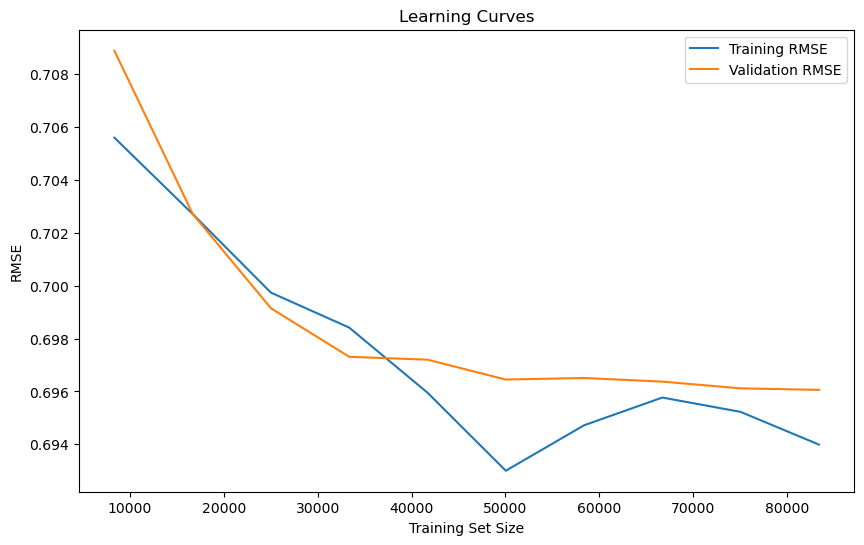

In [45]:
# Learning curves
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='neg_mean_squared_error',
    train_sizes=np.linspace(0.1, 1.0, 10))

train_rmse = np.sqrt(-train_scores.mean(axis=1))
test_rmse = np.sqrt(-test_scores.mean(axis=1))

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_rmse, label='Training RMSE')
plt.plot(train_sizes, test_rmse, label='Validation RMSE')
plt.xlabel('Training Set Size')
plt.ylabel('RMSE')
plt.title('Learning Curves')
plt.legend()
plt.show()

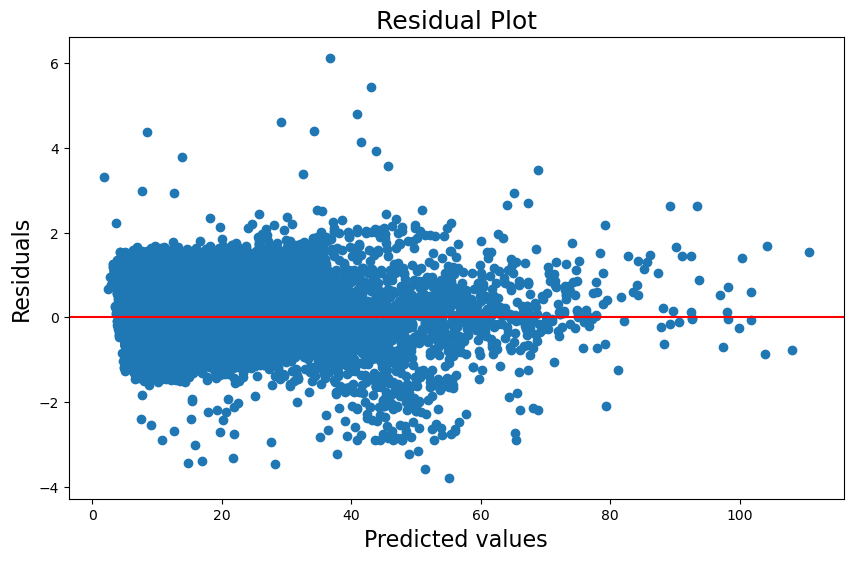

In [46]:
# Residual plot
y_pred = best_model.predict(X_test)
residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted values', fontsize = 16)
plt.ylabel('Residuals', fontsize = 16)
plt.title('Residual Plot', fontsize = 18)
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [47]:
# Final model evaluation
final_mse = mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)
print(f"Final Model Performance:")
print(f"MSE: {final_mse:.4f}")
print(f"RMSE: {np.sqrt(final_mse):.4f}")
print(f"R2: {final_r2:.4f}")

Final Model Performance:
MSE: 0.4736
RMSE: 0.6882
R2: 0.9966


In [48]:
# Cross-validation of final model
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='neg_mean_squared_error')
rmse_scores = np.sqrt(-cv_scores)
print(f"Cross-validated RMSE: {rmse_scores.mean():.4f} (+/- {rmse_scores.std() * 2:.4f})")

Cross-validated RMSE: 0.6960 (+/- 0.0196)


# Feature Importance

In [49]:
# Feature Importance Analysis
def analyze_feature_importance(model, X, feature_names):
    if hasattr(model, 'feature_importances_'):  # For tree-based models
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
        
        plt.figure(figsize=(10, 6))
        plt.title("Feature Importances")
        plt.bar(range(X.shape[1]), importances[indices])
        plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()
        
        return pd.DataFrame({'feature': feature_names, 'importance': importances})
    
    elif hasattr(model, 'coef_'):  # For linear models
        coefficients = model.coef_
        
        plt.figure(figsize=(10, 6))
        plt.title("Feature Coefficients")
        plt.bar(range(len(coefficients)), coefficients)
        plt.xticks(range(len(coefficients)), feature_names, rotation=90)
        plt.tight_layout()
        plt.show()
        
        return pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})

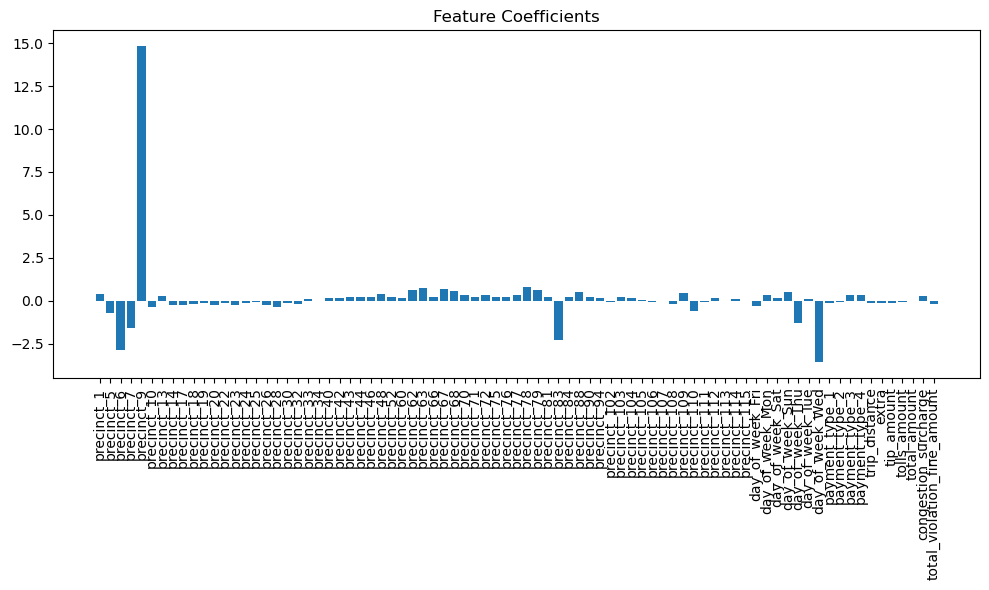

Feature Importance/Coefficients:
            feature  coefficient
4        precinct_9    14.835818
41      precinct_78     0.798618
31      precinct_63     0.753503
33      precinct_67     0.681551
30      precinct_62     0.641447
..              ...          ...
67  day_of_week_Thu    -1.295298
3        precinct_7    -1.601633
44      precinct_83    -2.302452
2        precinct_6    -2.852780
69  day_of_week_Wed    -3.573143

[81 rows x 2 columns]


In [54]:

feature_names = (
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .named_steps['onehot']
    .get_feature_names_out(categorical_columns).tolist() +
    numerical_columns
)
# Analyze feature importance
importance_df = analyze_feature_importance(best_model.named_steps['regressor'], 
                                           best_model.named_steps['preprocessor'].transform(X_test),
                                           feature_names)
print("Feature Importance/Coefficients:")
print(importance_df.sort_values('importance' if 'importance' in importance_df.columns else 'coefficient', 
                                ascending=False))

In [56]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import matplotlib.pyplot as plt
import shap

# Assuming 'best_model' is your trained model and 'X_test' is your test data

def analyze_specific_feature(model, X, feature_name):
    print(f"Analysis for feature: {feature_name}")
    
    # 1. Direct access (if applicable)
    if hasattr(model, 'feature_importances_'):  # For tree-based models
        feature_idx = list(X.columns).index(feature_name)
        importance = model.feature_importances_[feature_idx]
        print(f"Feature importance: {importance:.4f}")
    elif hasattr(model, 'coef_'):  # For linear models
        feature_idx = list(X.columns).index(feature_name)
        coefficient = model.coef_[feature_idx]
        print(f"Feature coefficient: {coefficient:.4f}")
    
    # 2. Permutation importance
    perm_importance = permutation_importance(model, X, y_test, n_repeats=10, random_state=42)
    feature_idx = list(X.columns).index(feature_name)
    perm_imp = perm_importance.importances_mean[feature_idx]
    perm_imp_std = perm_importance.importances_std[feature_idx]
    print(f"Permutation importance: {perm_imp:.4f} ± {perm_imp_std:.4f}")
    
    # 3. Partial dependence plot
    PartialDependenceDisplay.from_estimator(model, X, [feature_name])
    plt.title(f"Partial Dependence Plot for {feature_name}")
    plt.tight_layout()
    plt.show()
    
    # 4. SHAP values
    explainer = shap.Explainer(model, X)
    shap_values = explainer(X)
    
    shap.plots.scatter(shap_values[:, feature_name], color=shap_values)
    plt.title(f"SHAP values for {feature_name}")
    plt.tight_layout()
    plt.show()
    
    # Summary plot for context
    shap.summary_plot(shap_values, X, plot_type="bar")

# Use the function
analyze_specific_feature(best_model, X_test, 'total_violation_fine_amount')

ModuleNotFoundError: No module named 'shap'